In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd

from tqdm import tqdm

import gc

In [59]:
!wget https://files.grouplens.org/datasets/movielens/ml-latest.zip

In [56]:
!unzip ml-latest.zip

In [5]:
df = pd.read_csv('ml-latest/ratings.csv')

In [6]:
df.head()

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


### Рассмотрим диаграммы распределения

<Axes: >

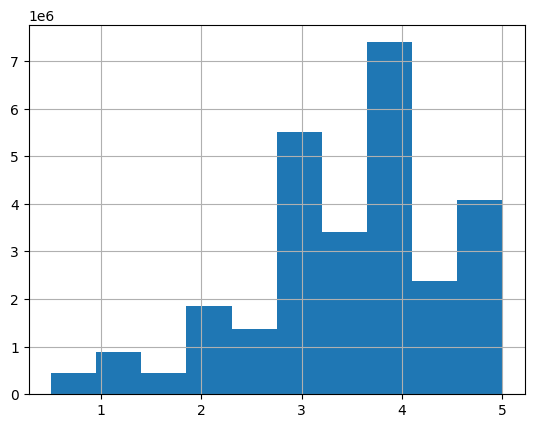

In [61]:
df.rating.hist()

Оценки имеют смещенное распределение

<Axes: >

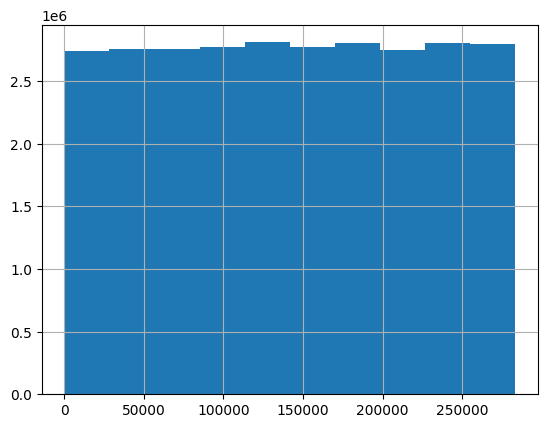

In [62]:
df.userId.hist()

Информации по интеракции каждого пользователя примерно одинаково для каждого пользователя 

<Axes: >

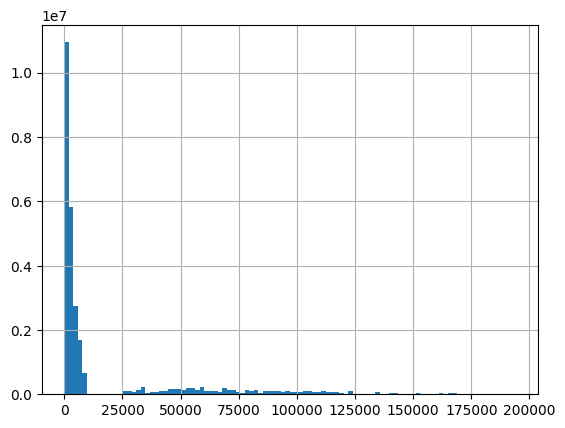

In [64]:
df.movieId.hist(bins=100)

Видно, что почти все интеракции приходятся на малый набор фильмов 

### Напишем обертку для датасета на pytorch


In [24]:
class MovieLensDataset(torch.utils.data.Dataset):
    def __init__(self, rating_path):
        df = pd.read_csv(rating_path)

        self.X = torch.hstack([
            torch.LongTensor(
                df.userId.to_numpy()
            ).reshape(df.shape[0], 1),
            torch.LongTensor(
                df.movieId.to_numpy()
            ).reshape(df.shape[0], 1)
        ])
        self.y = torch.tensor(df.rating.to_numpy(), 
                              dtype=torch.float32)
    
    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [25]:
full_dataset = MovieLensDataset('ml-latest/ratings.csv')

Разобьем данные на тренировочные и валидационные. Разбивать будем равновероятно, т.к. для каждого пользователя дано примерно равное количество записей об оценках

In [26]:
train_idx = np.random.choice(np.arange(len(full_dataset)), 
                             size=int(len(full_dataset) * 0.8),
                             replace=False)
val_idx = np.setdiff1d(np.arange(len(full_dataset)), train_idx)

In [28]:
train_dataset = torch.utils.data.Subset(full_dataset, train_idx)
val_dataset = torch.utils.data.Subset(full_dataset, val_idx)

In [50]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16384)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16384)

In [30]:
num_users = df.userId.max() + 1
num_movies = df.movieId.max() + 1
num_users, num_movies

(283229, 193887)

* Напишем модель, которая будет учитсья строить эмбеддинги. Отельно для пользователя и фильма будем строить латентные вектора, которые затем будут для получения итоговой оценки скалярно перемножаться и пропускаться через линейный слой и ReLU (т.к. оценка положительна). 

* Латентные вектора будут получаться последовательным пропусканием через полносвязные слои с функциями активации. Так как количество переменных сопоставимо с количеством данных, модель будет склонна к переобучению. Добавим Dropout-слоев.

In [70]:
class RatingPredictor(nn.Module):
    def __init__(self, num_users, num_movies, hidden_dim, ex_factor=4):
        super(RatingPredictor, self).__init__()
        self.u_emb = nn.Sequential(
            nn.Embedding(num_users, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, ex_factor*hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(ex_factor*hidden_dim, hidden_dim)
        )
        self.m_emb = nn.Sequential(
            nn.Embedding(num_movies, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, ex_factor*hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(ex_factor*hidden_dim, hidden_dim)
        )

        self.last_dropout = nn.Dropout(0.3)
        self.last_fc = nn.Linear(1, 1)
        self.last_relu = nn.ReLU()

    def get_user_embedding(self, idx : int) -> torch.tensor:
        """
            Returns embedding vector of user with `idx` id
        """

        return self.u_emb(torch.LongTensor([idx]))

    def get_movie_embedding(self, idx : int) -> torch.tensor:
        """
            Returns embedding vector of movie with `idx` id
        """

        return self.m_emb(torch.LongTensor([idx]))

    def forward(self, X):
        user_ids, movie_ids = X[:, 0], X[:, 1]
        u_latent = self.u_emb(user_ids)
        m_latent = self.m_emb(movie_ids)

        res = self.last_relu(
            self.last_fc(
                self.last_dropout(
                    torch.einsum("bkl,blk->bk", [
                        torch.unsqueeze(u_latent, 1),
                        torch.unsqueeze(m_latent, -1)
                    ])
                )
            )
        )

        return res

Так как в модели для получения итогового скора мы используем скалярное произведение вектора пользователя на вектор фильма, в качестве метрики близости будем использовать косинусное расстояние, поскольку именно отношение скалярного произведения к нормам векторов понимается под косинусом между многомерными векторами в $R^n$.


In [89]:
def get_similarity(user_vector : torch.tensor,
                   movie_vector : torch.tensor) -> float:
    """
        Returns similarity between user and vector
    """

    return nn.CosineSimilarity()(user_vector, movie_vector).item()

Обучим модель при помощи Adam-оптимизатора. В качестве лосса возьмем MSE.

In [83]:
model = RatingPredictor(num_users, num_movies, 128)

In [84]:
optim = torch.optim.Adam(model.parameters(), lr=5e-4)
criterion = nn.MSELoss()

In [87]:
train_loss = []
val_loss = []

num_epochs = 2

for epoch in range(num_epochs):
    cur_train_loss = []
    cur_val_loss = []

    model.train(True)
    for X_batch, y_batch in tqdm(train_loader):
        pred = model(X_batch)
        loss = criterion(pred, y_batch)

        loss.backward()
        optim.step()
        optim.zero_grad()

        cur_train_loss.append(loss.item())
        print(np.mean(cur_train_loss))

    model.train(False)
    for X_batch, y_batch in val_loader:
        with torch.no_grad():
            pred = model(X_batch)
            loss = criterion(pred, y_batch)
            cur_val_loss.append(loss.item())

    train_loss.append(np.mean(cur_train_loss))
    val_loss.append(np.mean(cur_val_loss))

    if epoch % 5 == 0:
        print(f"Last train loss: {train_loss[-1]}; Last val loss: {val_loss[-1]}")

Запустив обучение, получим построенные эмбеддинги. Проверить работоспособность можно например следующим образом:

In [91]:
get_similarity(
    model.get_user_embedding(1),
    model.get_movie_embedding(307)
)